# **Diario de Factores + Verificación Diaria Carrusel IR**
***
## *Gerencia de Inversionistas y Gestión de Capital*
<p style="text-align:center;">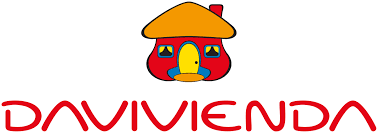</p>

# ***Introducción***
***
En este cuaderno se tiene el proceso de consolidación de información de tasas de interés y de cambio presentada en **Planeación GO**, que es visto por la Alta Gerencia de Davivienda.

Las principales fuentes de información son:
+ [Banco de la República](https://www.banrep.gov.co/es/estadisticas/catalog): IBRs, DTF, TRM, UVR, LIBORs (tienen 7 días de rezago), TIBR
+ [Superintendencia Financiera de Colombia](https://www.superfinanciera.gov.co/jsp/loader.jsf?lServicio=Publicaciones&lTipo=publicaciones&lFuncion=loadContenidoPublicacion&id=10829): IBC y Usura
+ [Banco Central de Honduras](https://www.bch.hn/): USDHNL
+ [Banco Central de Costa Rica](https://www.bccr.fi.cr/SitePages/Inicio.aspx): USDCRC
+ [Global Rates](https://www.global-rates.com/en/interest-rates/libor/libor.aspx): LIBORs de corte
+ [Trading Economics](https://tradingeconomics.com/): Crecimiento PIB
+ [DANE](https://www.dane.gov.co/): PIB y desempleo 13 ciudades.

# ***1. Preparación de Librerías y Configuración***

Abajo está la lista de las librerías que se utilizan a lo largo del proceso. Además se incluyen algunas modificaciones a las configuraciones base. **Lo más importante que cabe resaltar es que se modifica la opción de Pandas de advertir por operaciones encadenadas de asignación en los DataFrames**. Esta advertencia no tiene ningún impacto material sobre lo que ocurre en el proceso, pero es importante tener en mente que, para evitar la molestia de que aparezca en una asignación durante el proceso, se apaga. 


En caso de que no haya alguna librería, se debe utilizar el siguiente comando:

```python 
!pip install library_name
```

In [1]:
# !pip install selenium
# !pip install webdriver_manager
# !pip install pandas_datareader
# !pip install fredapi
# !pip install sodapy
# !pip install investpy
# !conda update --all

In [1]:
# Libreriras
import numpy as np
import pandas as pd
import re
from selenium import webdriver
from webdriver_manager.chrome import ChromeDriverManager 
from selenium.webdriver.chrome.options import Options
import time
import os  
import glob
import datetime
import io
from pandas_datareader.fred import FredReader as fred
import requests

import json
from bs4 import BeautifulSoup
import investpy
from dateutil.relativedelta import relativedelta
import dataframe_image as dfi
import seaborn as sns
import base64

from __future__ import print_function
from google.auth.transport.requests import Request
from google.oauth2.credentials import Credentials
from google_auth_oauthlib.flow import InstalledAppFlow
from googleapiclient.discovery import build
from googleapiclient.errors import HttpError
import googleapiclient

from email.mime.image import MIMEImage
from email.mime.multipart import MIMEMultipart
from email.mime.base import MIMEBase
from email.mime.text import MIMEText
import mimetypes

from typing import Union

cur_dir = os.getcwd()
# Librerias propias:
%load_ext autoreload
%autoreload 2
import hal01
# Configuraciones:
pd.options.mode.chained_assignment = None  # default='warn'

# ***2. Descarga y Limpieza de Datos Fuente***

En esta segunda sección se utiliza un bot para hacer la descarga automática de los datos desde las páginas fuente. En este caso son:

+ Catalogo de datos del [Banco de la República](https://www.banrep.gov.co/es/estadisticas/catalogo) para las tasas DTF, IBR (O/N, 1M, 3M y 6M), IPC, TRM, UVR, y TIBR
+ Página de publicación de IBC y Usura de la [Superintendencia Financiera de Colombia](https://www.superfinanciera.gov.co/jsp/loader.jsf?lServicio=Publicaciones&lTipo=publicaciones&lFuncion=loadContenidoPublicacion&id=10829) para la tasa de Usura e IBC 
+ Página del [Banco Central de Honduras](https://www.bch.hn/estadisticas-y-publicaciones-economicas/tipo-de-cambio-nominal) para la Lempira
+ Página del [Banco Central de Costa Rica](https://gee.bccr.fi.cr/indicadoreseconomicos/Cuadros/frmVerCatCuadro.aspx?idioma=1&CodCuadro=%20400) para el Colón

En resumen, lo que hace este bot es entrar, por medio de Google Chrome (específicamente este navegador, dada la [API utilizada](https://selenium-python.readthedocs.io/)), a cada una de las páginas listadas arriba. Para encontrar lo que se debe descargar se utilizan los [xpaths](https://es.wikipedia.org/wiki/XPath#:~:text=XPath%20(XML%20Path%20Language)%20es,la%20estructura%20jer%C3%A1rquica%20del%20XML.)(es básicamente la "dirección" del link en la página web, o ubicación absoluta en el documento HTML que está por debajo de la interfaz de la página que se visita). Se eligió esta forma de acceder a los datos debido a la forma en que funcionan los *requests* sobre la página del BanRep, que por tema de bloqueos y requerimientos sobre el *request* imposibilita acceder a estos datos por este medio. 

Una cosa que se deriva de esto, es que, si las páginas cambian de diseño o estructura, es crucial cambiar los xpaths de la página consultada por el bot. Esto es un evento poco frecuente, dado que las páginas no tienden a actualizarse a menudo. En caso de que esto ocurra, se debe cambiar tanto la URL (si esta cambia) y los xpaths de los archivos buscados. 

El bot descargará los archivos base en la carpeta que se haya colocado como destino (`download_path` abajo).

Esta primera variable global define el número de días que se presentan en el histórico que se pega en el Sheets de Data Studio. Para fines de semana se debe colocar 3, para un día normal 1. Esta es la única variable que se debe modificar en todo el proceso:

In [2]:
start_time = time.time()

# Número de días mostrados en formato Data Studio:
DIAS_DATA_STUDIO = 4
REF_DATE = (
    datetime.datetime.today()-
    datetime.timedelta(days=DIAS_DATA_STUDIO)
    ).replace(minute=0, hour=0, second=0, microsecond=0)
REF_DATE

datetime.datetime(2022, 7, 23, 0, 0)

En la celda de abajo se definen los directorios donde se buscan las series de validación, y donde se descargan las series nuevas:

In [3]:
validation_path = cur_dir+'\\validation_series\\'
series_path = cur_dir+'\\series\\'
data_error_log = []

Se eliminan las series que se descargaron durante la última corrida del proceso, de forma que no se generen conflictos con los nuevos datos descargados:

In [4]:
for file in os.listdir(series_path):
    os.remove(series_path+ file)

Se determina el lugar donde está el *driver* de Google Chrome utilizado por el bot y se genera una instancia del bot. **Es importante notar que si se actualiza la versión de Google Chrome, es necesario que se descargue el driver para la versión nueva**. Para lograr esto simplemente se debe colocar `True` en el atributo `install_driver`:

```python
br_download = hal01.ChromeDownload(
    download_path = series_path,
    install_driver = True,
)
```
Esto hace que se descargue el driver necesario. Y para futuras ejecuciones, simplemente se reemplaza el `chrome_path` por la ruta que aparece tras las descarga automática

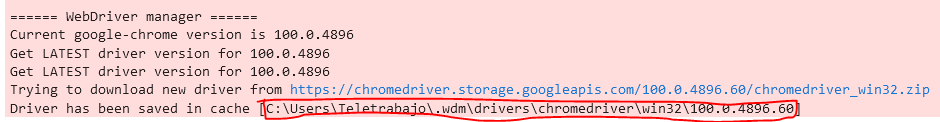

Se inicia con los archivos del Banco de la Republica:

In [5]:
chrome_path = 'C:\\Users\\Teletrabajo\\.wdm\\drivers\\chromedriver\\win32\\100.0.4896.60\\chromedriver.exe'

In [6]:
"""
Se hace un try/except para intentar utilizar el bot sobre la pagina del BanRep
una sola vez. Sin embargo, a veces se generan bloqueos anti-bots. Por esto se
coloca un except que va directamente a cada link.
"""
banrep_data_error_log = None

try:
    # Inicia una instancia del bot llamando a la librería propia:
    br_download = hal01.ChromeDownload(
        download_path = series_path, 
        install_driver = False,
        chrome_driver_path = chrome_path
    )

    # El bot inicia la descarga de archivos en el BanRep:
    br_download.download_files(
        xpaths = hal01.BANREP_XPATHS,
        url = hal01.URL_BANREP,
        remove_files=True
    )
except:
    try:
        chrm_opt = Options()
        chrm_opt.add_experimental_option("prefs", {
                    "download.default_directory": series_path
                })
        browser = webdriver.Chrome(
                executable_path = chrome_path,
                options = chrm_opt
            )
        for url in hal01.BANREP_LINK_LIST:
            browser.get(url)
        time.sleep(5)
        browser.close()
    except:
        banrep_data_error_log = """
        Página del BanRep presentó problemas para descarga.
        (TIBR, TRM, IPC, UVR, IBRs)\n
        """
        if banrep_data_error_log:
            data_error_log.append(banrep_data_error_log)

UVR series clicked!
TIBR series clicked!
IBR O/N series clicked!
IBR 1M series clicked!
IBR 3M series clicked!
IBR 6M series clicked!
IBR 12M series clicked!
DTF series clicked!
TRM series clicked!
LIBOR series clicked!


Se ejecuta el método que inicia el bot para que descargue los archivos:

In [7]:
bccr_data_error_log = None
try:
    browser = hal01.ChromeDownload(
        download_path = series_path,
        install_driver = False,
        chrome_driver_path = chrome_path
    )
    browser.download_files(
        xpaths = hal01.COLON_XPATH, 
        close_time = 10, 
        url = hal01.URL_COLON
    )
except:
    bccr_data_error_log = """
    Página del Banco Central de Honduras presentó problemas para descarga.
    (Lempira).\n\n
    """
    if bccr_data_error_log:
        data_error_log.append(bccr_data_error_log)

colon series clicked!


Esto ayuda a validar que todos los archivos quedaron descargados. Cada símbolo representa:

+ TCA: DTF,
+ TCM: TRM,
+ TIP: TIBR,
+ CatCuadro: Colon
+ Dólar: Lempira

In [8]:
files_dict = {}
for key in hal01.FILE_PATTERNS.keys():
    temp_path = os.path.join(series_path, f'*{key}*')
    try:
        files_dict[hal01.FILE_PATTERNS[key]] = glob.glob(temp_path)[0]
    except:
        print("------------------------- WARNING-----------------------------")
        print(f'The series {hal01.FILE_PATTERNS[key]} was not found')
del(temp_path)

Se limpian los archivos Excel descargados para que sean interpretables y colocados en el formato necesario:

In [9]:
user_agent = 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/100.0.4896.75 Safari/537.36'
headers = {'User-Agent': user_agent}

In [10]:
#------------------------------DTF---------------------------------------------
try:
    dtf_df = hal01.clean_excel_file(
        file_path = files_dict['DTF'], 
        skiprows = 11,
        column_names = ['Fecha','hasta','DTF'],
        drop_columns = ['CDT 180 %', 'CDT 360 %', 'TCC %'],
        as_percentage = 'DTF',
        subset_dropna = ['Vigencia hasta (dd/mm/aaaa)'],
        value_columns = 'DTF'
    )

    # Data Validation:
    dtf_val = pd.read_csv(validation_path+'dtf.csv').astype({
        'Fecha':'datetime64[ns]'}
    )
    comparison = dtf_val.merge(dtf_df, how='left', on='Fecha')
    diff = (comparison['DTF_x']-comparison['DTF_y']).sum()
    if diff>0.001:
        raise Exception
    else:
        dtf_df.to_csv(validation_path+'dtf.csv', index=False)

except:
    dtf_df = pd.read_csv(validation_path+'dtf.csv').astype({
        'Fecha':'datetime64[ns]'}
    )
    dtf_df = hal01.total_day_series(dtf_df, value_columns='DTF')
    data_error_log.append("Procesamiento de DTF fallido. Revisar. \n")

In [11]:
#------------------------------TRM---------------------------------------------
try:
    trm_df = hal01.clean_excel_file(
        file_path = files_dict['TRM'],
        skiprows = 7,
        column_names = ['Fecha','TRM'],
        drop_columns = [],
        subset_dropna = ['Tasa de cambio representativa del mercado (TRM)'],
        value_columns = 'TRM'   
    )
    trm_df['DEV. TRM'] = (trm_df['TRM']/trm_df['TRM'].shift(365)-1)
    trm_df.dropna(inplace=True)

    # Data Validation:
    trm_val = pd.read_csv(validation_path+'trm.csv').astype({
        'Fecha':'datetime64[ns]'}
    )
    comparison = trm_val[['Fecha','TRM']].merge(trm_df[['Fecha','TRM']], 
                                                how='left', on='Fecha')
    diff = (comparison['TRM_x']-comparison['TRM_y']).sum()
    if diff>0.001:
        raise Exception
    else:
        trm_df.to_csv(validation_path+'trm.csv', index=False)
except:
    trm_df = pd.read_csv(validation_path+'trm.csv').astype({
        'Fecha':'datetime64[ns]'}
    )
    trm_df = hal01.total_day_series(trm_df, value_columns=['TRM', 'DEV. TRM'])
    data_error_log.append("Procesamiento de TRM fallido. Revisar. \n")

In [12]:
#------------------------------UVR---------------------------------------------
try:
    uvr_df = hal01.clean_excel_file(
        file_path = files_dict['UVR'],
        skiprows = 7,
        column_names = ['Fecha','UVR','%UVR'],
        drop_columns = [],
        as_percentage = '%UVR',
        subset_dropna = ['Variación anual porcentual %'],
        value_columns = ['UVR','%UVR']
    )

    # Data Validation:
    uvr_val = pd.read_csv(validation_path+'uvr.csv').astype({
        'Fecha':'datetime64[ns]'}
    )
    comparison = uvr_val[['Fecha','UVR']].merge(uvr_df[['Fecha','UVR']], 
                                                how='left', on='Fecha')
    diff = (comparison['UVR_x']-comparison['UVR_y']).sum()
    if diff>0.001:
        raise Exception
    else:
        uvr_df.to_csv(validation_path+'uvr.csv', index=False)
except:
    uvr_df = pd.read_csv(validation_path+'uvr.csv').astype({
        'Fecha':'datetime64[ns]'}
    )
    uvr_df = hal01.total_day_series(uvr_df, value_columns=['UVR', '%UVR'])
    data_error_log.append("Procesamiento de UVR fallido. Revisar. \n")

In [15]:
#------------------------------IBRs--------------------------------------------
try:
    ibr_on = hal01.ibr_series(files_dict['IBR_ON'],
                        name='IBR Overnight')
    ibr_1m =  hal01.ibr_series(files_dict['IBR_1M'], name='IBR 1M')
    ibr_3m =  hal01.ibr_series(files_dict['IBR_3M'], name='IBR 3M')
    ibr_6m =  hal01.ibr_series(files_dict['IBR_6M'], name='IBR 6M')
    ibr_12m =  hal01.ibr_series(files_dict['IBR_12M'], name='IBR 12M')
    
    # Data validation:
    ibron_val = pd.read_csv(validation_path+'ibron.csv').astype({
        'Fecha':'datetime64[ns]'}
    )
    ibr1m_val = pd.read_csv(validation_path+'ibr1m.csv').astype({
        'Fecha':'datetime64[ns]'}
    )
    ibr3m_val = pd.read_csv(validation_path+'ibr3m.csv').astype({
        'Fecha':'datetime64[ns]'}
    )
    ibr6m_val = pd.read_csv(validation_path+'ibr6m.csv').astype({
        'Fecha':'datetime64[ns]'}
    )
    ibr12m_val = pd.read_csv(validation_path+'ibr12m.csv').astype({
        'Fecha':'datetime64[ns]'}
    )
    ibr_df_dict = {'IBR Overnight':ibr_on, 'IBR 1M':ibr_1m, 'IBR 3M':ibr_3m, 
                   'IBR 6M':ibr_6m, 'IBR 12M':ibr_12m}
    ibr_df_val = [ibron_val, ibr1m_val, ibr3m_val, ibr6m_val, ibr12m_val]

    for i, key in enumerate(ibr_df_dict.keys()):
        comparison = ibr_df_val[i].merge(ibr_df_dict[key], on='Fecha', how='left')
        diff = (comparison[key+'_x']-comparison[key+'_y']).sum()
        if diff>0.01:
            raise Exception
        else:
            ibr_on.to_csv(validation_path+'ibron.csv', index=False)
            ibr_1m.to_csv(validation_path+'ibr1m.csv', index=False)
            ibr_3m.to_csv(validation_path+'ibr3m.csv', index=False)
            ibr_6m.to_csv(validation_path+'ibr6m.csv', index=False)
            ibr_12m.to_csv(validation_path+'ibr12m.csv', index=False)
except:
    ibr_on = pd.read_csv(validation_path+'ibron.csv').astype({
        'Fecha':'datetime64[ns]'}
    )
    ibr_on = hal01.total_day_series(
        df = ibr_on, 
        value_columns = ['IBR Overnight_e', 'IBR Overnight']
    )
    ibr_1m = pd.read_csv(validation_path+'ibr1m.csv').astype({
        'Fecha':'datetime64[ns]'}
    )
    ibr_1m = hal01.total_day_series(
        df = ibr_1m, 
        value_columns = ['IBR 1M_e', 'IBR 1M']
    )
    ibr_3m = pd.read_csv(validation_path+'ibr3m.csv').astype({
        'Fecha':'datetime64[ns]'}
    )
    ibr_3m = hal01.total_day_series(
        df = ibr_3m, 
        value_columns = ['IBR 3M_e', 'IBR 3M']
    )
    ibr_6m = pd.read_csv(validation_path+'ibr6m.csv').astype({
        'Fecha':'datetime64[ns]'}
    )
    ibr_6m = hal01.total_day_series(
        df = ibr_6m, 
        value_columns = ['IBR 6M_e', 'IBR 6M']
    )
    ibr_12m = pd.read_csv(validation_path+'ibr12m.csv').astype({
        'Fecha':'datetime64[ns]'}
    )
    ibr_12m = hal01.total_day_series(
        df = ibr_12m, 
        value_columns = ['IBR 12M_e', 'IBR 12M']
    )
    data_error_log.append("Procesamiento de IBRs fallido. Revisar. \n")

Para el IPC se toma como fuente al DANE. Para esto se utiliza la librería de `requests`, que permite una comunicación más directa con la página donde mensualmente se publica el dato de inflación. 

In [16]:
#------------------------------IPC---------------------------------------------
try:
    ipc_date = datetime.datetime.today() - relativedelta(months=1)
    month = hal01.SPN_DATE_DICT[ipc_date.strftime('%b').lower()]
    year = ipc_date.strftime('%y')

    # Variación IPC mensual:
    url_ipc_mes = f'https://www.dane.gov.co/files/investigaciones/ipc/{month+year}/IPC_divisiones_mensuales.xlsx'
    r = requests.get(url=url_ipc_mes, headers=headers, stream=True, verify=False)
    with io.BytesIO(r.content) as file:
        df = pd.read_excel(file, skiprows=8, sheet_name=0)
    ipc_mes = df.loc[
        df['Mes'] == 'Total IPC',
        hal01.FULL_SPN_DATE_DICT[ipc_date.month]
        ].item()

    # Variación IPC anual:
    url_ipc_year = f'https://www.dane.gov.co/files/investigaciones/ipc/{month+year}/IPC_divisiones_anuales.xlsx'
    r = requests.get(url=url_ipc_year, headers=headers, stream=True, verify=False)
    with io.BytesIO(r.content) as file:
        df = pd.read_excel(file, skiprows=8, sheet_name=0)
    ipc_year = df.loc[
        df['Mes'] == 'Total IPC',
        hal01.FULL_SPN_DATE_DICT[ipc_date.month]
        ].item()

    # Indice:
    url_indice = f'https://www.dane.gov.co/files/investigaciones/ipc/{month+year}/IPC_Indices.xlsx'
    r = requests.get(url=url_indice, headers=headers, stream=True, verify=False)
    with io.BytesIO(r.content) as file:
        df = pd.read_excel(file, skiprows=8, sheet_name=0)
    indice = df.loc[
        df['Mes'] == hal01.FULL_SPN_DATE_DICT[ipc_date.month],
        ipc_date.year
        ].item() 

    # Agregar ultima observación al histórico
    dt = datetime.datetime.combine(datetime.date.today(), 
                                   datetime.datetime.min.time())
    ipc_df = pd.read_csv(validation_path+'ipc.csv').astype({
            'Fecha': 'datetime64[ns]'
        }).set_index('Fecha')
    ipc_df.loc[dt, :] = (indice, ipc_year/100, ipc_mes/100)
    ipc_df = ipc_df.reset_index()
    ipc_df = hal01.total_day_series(
        df = ipc_df, 
        value_columns = ['Indice','IPC Anual', 'IPC Mensual']
    )
    ipc_df.to_csv(validation_path+'ipc.csv', index=False)
    print('ok')
except:
    ipc_df = pd.read_csv(validation_path+'ipc.csv').astype({
        'Fecha': 'datetime64[ns]'
    })
    ipc_df = hal01.total_day_series(
        df = ipc_df, 
        value_columns = ['Indice', 'IPC Anual', 'IPC Mensual']
    )
    if datetime.date.today().day > 5:
        data_error_log.append("Procesamiento de IPC fallido. Revisar. \n")

C:\Users\Teletrabajo\anaconda3\lib\site-packages\urllib3\connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.dane.gov.co'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
C:\Users\Teletrabajo\anaconda3\lib\site-packages\urllib3\connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.dane.gov.co'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
C:\Users\Teletrabajo\anaconda3\lib\site-packages\urllib3\connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.dane.gov.co'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


ok


In [17]:
#------------------------------TIBR--------------------------------------------
try:
    tibr_df = hal01.clean_excel_file(
        file_path = files_dict['TIBR'],
        skiprows = 7,
        column_names = ['Fecha','TIBR'],
        as_percentage = 'TIBR',
        subset_dropna = ['Tasa de intervención de política monetaria (%)'],
        value_columns = 'TIBR'
    )

    # Data Validation:
    tibr_val = pd.read_csv(validation_path+'tibr.csv').astype({
        'Fecha':'datetime64[ns]'}
    )
    comparison = tibr_val.merge(tibr_df, how='left', on='Fecha')
    diff = (comparison['TIBR_x']-comparison['TIBR_y']).sum()
    if diff>0.001:
        raise Exception
    else:
        tibr_df.to_csv(validation_path+'tibr.csv', index=False)
except:
    tibr_df = pd.read_csv(validation_path+'tibr.csv').astype({
        'Fecha':'datetime64[ns]'}
    )
    tibr_df = hal01.total_day_series(tibr_df, value_columns='TIBR')
    data_error_log.append("Procesamiento de TIBR fallido. Revisar. \n")

In [18]:
# Arreglar IBC y Usura:
sfc_data_error_log = None
try:
    ibc_usura_df = pd.read_excel(
        io = hal01.URL_SFC,
        skiprows = 1,
        usecols = [0,1,2,3]).dropna(
        subset = ['INTERÉS ANUAL EFECTIVO','DESDE','HASTA']).drop(
        columns = ['HASTA']
    )
    ibc_usura_df.columns = ['Fecha','IBC','USURA']
    ibc_usura_df = ibc_usura_df[ibc_usura_df['IBC'].apply(
        func = lambda x: isinstance(x, float)
    )]
    ibc_usura_df = ibc_usura_df[ibc_usura_df['Fecha'].apply(
        func = lambda x: isinstance(x, datetime.datetime)
    )]
    ibc_usura_df['Fecha'] = pd.to_datetime(ibc_usura_df['Fecha'])
    ibc_usura_df.sort_values(by='Fecha', inplace=True)
    ibc_usura_df = hal01.total_day_series(ibc_usura_df,'Fecha',['IBC','USURA'])

    # Data Validation:
    ibc_usura_val = pd.read_csv(validation_path+'ibc_usura.csv').astype({
        'Fecha':'datetime64[ns]'}
    )
    comparison = ibc_usura_val[['Fecha','IBC']].merge(ibc_usura_df[['Fecha','IBC']],
                                                      how='left', on='Fecha')
    diff = (comparison['IBC_x']-comparison['IBC_y']).sum()
    if diff>0.001:
        raise Exception
    else:
        ibc_usura_df.to_csv(validation_path+'ibc_usura.csv', index=False)
except:
    ibc_usura_df = pd.read_csv(validation_path+'ibc_usura.csv').astype({
        'Fecha':'datetime64[ns]'}
    )
    ibc_usura_df = hal01.total_day_series(ibc_usura_df, 
                                          value_columns=['IBC','USURA'])
    sfc_data_error_log = """
    Archivo de la SuperFinanciera presento problemas. Revisar.
    (Tasa de Usura, IBC).\n
    """
    data_error_log.append(sfc_data_error_log)

In [19]:
# Arreglar Lempira:
bch_data_error_log = None
try:
    lempira_df = pd.read_excel(hal01.URL_LEMPIRA, skiprows=6)
    lempira_df = lempira_df.dropna(subset = ['Venta'])
    lempira_df = lempira_df[['Fecha', 'Compra 1/', 'Venta']]
    lempira_df.columns = ['Fecha','USDHNL','LEMPIRA/USD']
    lempira_df = lempira_df[lempira_df['Fecha'].apply(
        func = lambda x: isinstance(x, datetime.datetime)
        )].astype({'Fecha':'datetime64[ns]'})
    lempira_df.sort_values(by='Fecha', inplace=True)
    lempira_compra_df = hal01.total_day_series(lempira_df, 'Fecha', 'USDHNL')
    lempira_df = hal01.total_day_series(lempira_df,'Fecha',
                                        ['LEMPIRA/USD', 'USDHNL'])
    lempira_df['DEV. LEMPIRA'] = (lempira_df['LEMPIRA/USD']/lempira_df['LEMPIRA/USD']\
                                  .shift(365)-1)
    lempira_df.dropna(inplace=True)

    # Data Validation:
    lempira_val = pd.read_csv(validation_path+'lempira.csv').astype({
        'Fecha':'datetime64[ns]'}
    )
    comparison = lempira_val[['Fecha','LEMPIRA/USD']].merge(
        lempira_df[['Fecha','LEMPIRA/USD']],
        how = 'left', 
        on = 'Fecha'
    )
    diff = (comparison['LEMPIRA/USD_x']-comparison['LEMPIRA/USD_y']).sum()
    if diff>0.02:
        raise Exception
    else:
        lempira_df.to_csv(validation_path+'lempira.csv', index=False)
except:
    lempira_df = pd.read_csv(validation_path+'lempira.csv').astype({
        'Fecha':'datetime64[ns]'}
    )
    lempira_df = hal01.total_day_series(
        df = lempira_df, 
        value_columns = ['LEMPIRA/USD', 'DEV. LEMPIRA']
    )
    bch_data_error_log = """
    Archivo del Banco Central de Honduras presentó problemas. Revisar.
    (Lempira).\n\n
    """
    data_error_log.append(bch_data_error_log)

In [20]:
# Arreglar Colon: 
try:
    # Opening the file using special encoding
    file1 = io.open(files_dict['COLON'], "r", encoding="iso-8859-1")
    data = file1.readlines()
    COLUMNS = ['Unnamed: 0', 'TIPO CAMBIO COMPRA', 'TIPO DE CAMBIO VENTA']
    # Give correct format to dates and clean data:
    html_data = ''.join(data)
    trans_table = {
        ',': '.',
        'Ene': 'Jan',
        'Ago': 'Aug',
        'Dic': 'Dec',
        'Set': 'Sep',
        'Abr': 'Apr'
    }
    for key, value in trans_table.items():
        html_data = html_data.replace(key, value)

    html_data = html_data.translate(trans_table)
    colon_df  = pd.read_html(html_data, header = 4)[0][COLUMNS]
    colon_df.columns = ['Fecha','USDCRC','COLON/USD']
    colon_df = colon_df.dropna(subset=['USDCRC','COLON/USD'])
    colon_df['Fecha'] = pd.to_datetime(colon_df['Fecha'], format='%d %b %Y')
    colon_df = hal01.total_day_series(colon_df, 
                                      value_columns=['USDCRC','COLON/USD'])
    colon_df.sort_values(by='Fecha', inplace=True)
    colon_df['DEV. COLON'] = colon_df['COLON/USD']/colon_df['COLON/USD'].shift(365)-1
    colon_df.dropna(inplace=True)

    # Data Validation:
    colon_val = pd.read_csv(validation_path+'colon.csv').astype({
        'Fecha':'datetime64[ns]'}
    )
    comparison = colon_val[['Fecha','COLON/USD']].merge(
        colon_df[['Fecha','COLON/USD']],
        how = 'left', 
        on = 'Fecha'
    )
    diff = (comparison['COLON/USD_x']-comparison['COLON/USD_y']).sum()
    if diff>0.001:
        raise Exception
    else:
        colon_df.to_csv(validation_path+'colon.csv', index=False)
except:
    colon_df = pd.read_csv(validation_path+'colon.csv').astype({
        'Fecha':'datetime64[ns]'}
    )
    colon_df = hal01.total_day_series(
        df = colon_df, 
        value_columns=['USDCRC','COLON/USD', 'DEV. COLON']
    )
    data_error_log.append("Procesamiento de Colon fallido. Revisar. \n")

En esta parte se utilizan APIs que se conectan directamente con la información de la Reserva Federal de Estados Unidos, específicamente la [Fed de St. Louis](https://fred.stlouisfed.org/). Para obtener los últimos datos de la LIBOR6M (dado que la Fed publica este dato con una semana de rezago), se utiliza esta [página](https://www.global-rates.com/en/interest-rates/libor/american-dollar/usd-libor-interest-rate-6-months.aspx), y la opción de leer tablas directamente de [HTML que tiene Pandas](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_html.html).

In [21]:
#---------------------------Arreglar tasas USD---------------------------------
start = '2006-01-01'
fred_data_error_log = None

try:
    # SOFR
    sofr_df = fred('SOFR', start=start).read().fillna(method='ffill')/100
    sofr_df = sofr_df.reset_index().rename(columns = {'DATE':'Fecha'})
    sofr_df = hal01.total_day_series(sofr_df, 'Fecha', 'SOFR')
    sofr_df.to_csv(validation_path+'sofr.csv', index=False)

    # FFR
    ffr_df = fred('DFEDTARU', start=start).read().fillna(method='ffill')/100
    ffr_df = ffr_df.reset_index().rename(
        columns = {'DATE':'Fecha', 'DFEDTARU':'FED'}
    )
    ffr_df = hal01.total_day_series(ffr_df, 'Fecha','FED')
    ffr_df.to_csv(validation_path+'ffr.csv', index=False)
    
except:
    fred_data_error_log = """
    API de la Fed presentó problemas para descarga.
    (SOFR, FFR).\n
    """
    if fred_data_error_log:
        data_error_log.append(fred_data_error_log)
    sofr_df = pd.read_csv(validation_path+'sofr.csv').astype({
        'Fecha':'datetime64[ns]'}
    )
    sofr_df = hal01.total_day_series(sofr_df, value_columns='SOFR')
    
    ffr_df = pd.read_csv(validation_path+'ffr.csv', index=False).astype({
        'Fecha':'datetime64[ns]'}
    )
    sofr_df = hal01.total_day_series(ffr_df, value_columns='FED')

In [22]:
# Term SOFR CME:
term_sofr_dict = {
    623206: 'SOFR 6M',
    663077: 'SOFR 3M',
    401927: 'SOFR 1M',
    729303: 'SOFR 1Y'
}
t_sofr = ['SOFR 1M', 'SOFR 3M', 'SOFR 6M', 'SOFR 1Y']
term_sofr_df = pd.read_csv('validation_series/term_sofr.csv',
                             parse_dates=['Fecha'], index_col='Fecha')

try:
    last_date = term_sofr_df.index.max()
    
    # CME API credentials:
    api_name = 'api_adg_davivienda'
    api_password = 'AG#9j9a7tergen7JNQmQ#Ead'
    
    # CME API request:
    cme_product_url = 'https://datamine.cmegroup.com/cme/api/v1/list'
    r = requests.get(cme_product_url, auth=(api_name, api_password))
    json_response = json.loads(r.text)
    
    # Search for the new data and append to historic table:
    for j in json_response['files']:
        fid = j['fid']
        order = j['orderid']
        date = datetime.datetime.strptime(j['yyyymmdd'], '%Y%m%d')
        if 'CSV' in fid and order=='42108' and date>last_date:
            r = requests.get(j['url'], auth=(api_name, api_password))
            with io.BytesIO(r.content) as file:
                temp = pd.read_csv(file)
            temp['date'] = pd.to_datetime(temp['businessDate'], format='%m-%d-%Y')
            temp = temp.pivot(index='date', columns='securityId', values='rate')
            temp = temp.rename(columns=term_sofr_dict)
            term_sofr_df.loc[date] = temp[t_sofr].values[0]/100
        else:
            continue
    term_sofr_df = term_sofr_df.sort_index().reset_index()
    term_sofr_df = hal01.total_day_series(
            df = term_sofr_df,
            value_columns = t_sofr
    )
    term_sofr_df.to_csv(validation_path+'term_sofr.csv', index=False)
except:
    term_sofr_df = pd.read_csv(validation_path+'term_sofr.csv',
                               parse_dates=['Fecha'])
    term_sofr_df = hal01.total_day_series(term_sofr_df, value_columns=t_sofr)
    data_error_log.append("Procesamiento de Term SOFR CME fallido. Revisar.\n")

In [23]:
# LIBOR6M y LIBOR 3M
globlarates_data_error_log = None
try:
    url_current = 'https://www.global-rates.com/en/interest-rates/libor/american-dollar/usd-libor-interest-rate-3-months.aspx'
    current_rates3m = pd.read_html(url_current, match='Current interest rates',
                                 header=0)[-1]
    url_current = 'https://www.global-rates.com/en/interest-rates/libor/american-dollar/usd-libor-interest-rate-6-months.aspx'
    current_rates6m = pd.read_html(url_current, match='Current interest rates',
                                 header=0)[-1]
    current_rates6m.columns = ['Fecha', 'LIBOR 6M']
    current_rates3m.columns = ['Fecha', 'LIBOR 3M']
    current_rates = current_rates3m.merge(current_rates6m, on='Fecha')
    current_rates['Fecha'] = pd.to_datetime(
        current_rates['Fecha'], 
        format = '%B %d %Y'
    )
    rates = ['LIBOR 3M', 'LIBOR 6M']
    current_rates[rates] = current_rates[rates].apply(
        lambda x: x.str.replace("[^a-zA-Z0-9.,]", "", regex=True).astype(float)
    )

    # Historico BanRep:
    libor_df = pd.read_excel(files_dict['LIBOR'],skiprows=9).dropna(
        subset = ['1 mes', 'Fecha (dd/mm/aaaa)']
    )
    libor_df.columns = ['Fecha', 'LIBOR 1M', 'LIBOR 2M', 'LIBOR 3M', 'LIBOR 6M', 
                        'LIBOR 12M']
    libor_df = libor_df.loc[
        libor_df['Fecha'].apply(lambda x: isinstance(x, datetime.datetime)), :
    ]
    libor_df = libor_df.reset_index(drop=True).sort_values(by='Fecha')
    libor_df = libor_df[['Fecha', 'LIBOR 3M', 'LIBOR 6M']]
    libor_df['Fecha'] = pd.to_datetime(libor_df['Fecha'])
    libor_df[rates] = libor_df[rates]

    libor_df = libor_df.merge(current_rates, on=list(current_rates.columns), 
                              how='outer')
    libor_df[rates] = libor_df[rates]/100
    libor_df = hal01.total_day_series(libor_df, 
                                      value_columns=rates).drop_duplicates()
    libor_df.to_csv(validation_path+'hist_libor.csv', index=False)
    libor_df = libor_df[['Fecha', 'LIBOR 3M', 'LIBOR 6M']]
    
except:
    globalrates_data_error_log = """
    Conexion con Global Rates esta presentando problemas.
    (LIBOR 6M).\n
    """
    if globalrates_data_error_log:
        data_error_log.append(globalrates_data_error_log)
    libor_df = pd.read_csv(validation_path+'hist_libor.csv', 
                           usecols=['Fecha', 'LIBOR 6M']).astype({
        'Fecha':'datetime64[ns]'}
    )
    libor_df = hal01.total_day_series(
        df = libor_df, 
        value_columns = ['LIBOR 3M', 'LIBOR 6M']
    )
    

Se unen todas las tablas en el orden y formato necesario para producir las tablas objetivo:

In [24]:
# Join Data:
df_final = tibr_df.merge(ibr_on[['Fecha', 'IBR Overnight']], 
                         on=['Fecha'],how='left')
df_final = df_final.merge(ibr_1m[['Fecha', 'IBR 1M']], on=['Fecha'],how='left')
df_final = df_final.merge(ibr_3m[['Fecha', 'IBR 3M']], on=['Fecha'],how='left')
df_final = df_final.merge(ibr_6m[['Fecha', 'IBR 6M']], on=['Fecha'],how='left')
df_final = df_final.merge(
    right = ibr_12m[['Fecha', 'IBR 12M']], 
    on = ['Fecha'],
    how = 'left'
)
df_final = df_final.merge(dtf_df, on=['Fecha'],how='left')
df_final = df_final.merge(ipc_df, on=['Fecha'],how='left')
df_final = df_final.merge(ffr_df, on=['Fecha'],how='left')
df_final = df_final.merge(uvr_df, on=['Fecha'],how='left')
df_final = df_final.merge(ibc_usura_df, on=['Fecha'],how='left')
df_final = df_final.merge(trm_df, on=['Fecha'],how='left')
df_final = df_final.merge(libor_df, on=['Fecha'],how='left')
df_final = df_final.merge(sofr_df, on=['Fecha'],how='left')
df_final = df_final.merge(term_sofr_df, on=['Fecha'], how='left')
df_final = df_final.merge(lempira_df[['Fecha', 'LEMPIRA/USD', 'DEV. LEMPIRA']], 
                          on=['Fecha'], how='left')
df_final = df_final.merge(colon_df[['Fecha', 'COLON/USD', 'DEV. COLON']], 
                          on=['Fecha'],how='left').drop_duplicates()
df_final.tail()

,Fecha,TIBR,IBR Overnight,IBR 1M,IBR 3M,IBR 6M,IBR 12M,DTF,Indice,IPC Anual,...,LIBOR 6M,SOFR,SOFR 1M,SOFR 3M,SOFR 6M,SOFR 1Y,LEMPIRA/USD,DEV. LEMPIRA,COLON/USD,DEV. COLON
8604,2022-07-23,0.075,0.07135,0.08241,0.08788,0.09775,0.10925,0.0875,119.31,0.0967,...,0.033229,0.0152,0.022846,0.025588,0.029792,0.032350,24.6163,0.030790,675.61,0.086941
8605,2022-07-24,0.075,0.07135,0.08241,0.08788,0.09775,0.10925,0.0875,119.31,0.0967,...,0.033229,0.0152,0.022846,0.025588,0.029792,0.032350,24.6163,0.030790,675.61,0.086731
8606,2022-07-25,0.075,0.07117,0.08306,0.08816,0.09790,0.10813,0.0928,119.31,0.0967,...,0.032853,0.0153,0.022846,0.025588,0.029792,0.032350,24.6221,0.031033,675.61,0.086731
8607,2022-07-26,0.075,0.07129,0.08315,0.08863,0.09790,0.10873,0.0928,119.31,0.0967,...,0.033464,0.0153,0.023218,0.025636,0.029426,0.031245,24.6245,0.030172,675.61,0.086731
8608,2022-07-27,0.075,0.07110,0.08385,0.08876,0.09777,0.10765,0.0928,119.31,0.0967,...,0.033464,0.0153,0.023218,0.025636,0.029426,0.031245,24.6270,0.030608,675.87,0.087150


In [25]:
# Effective Data:
dfe_final = tibr_df.merge(ibr_on[['Fecha', 'IBR Overnight_e']], 
                         on=['Fecha'],how='left')
dfe_final = dfe_final.merge(
    right = ibr_1m[['Fecha', 'IBR 1M_e']], 
    on = ['Fecha'],
    how = 'left'
)
dfe_final = dfe_final.merge(
    right = ibr_3m[['Fecha', 'IBR 3M_e']], 
    on = ['Fecha'], 
    how = 'left'
)
dfe_final = dfe_final.merge(
    right = ibr_6m[['Fecha', 'IBR 6M_e']], 
    on = ['Fecha'],
    how = 'left'
)
dfe_final = dfe_final.merge(
    right = ibr_12m[['Fecha', 'IBR 12M_e']], 
    on = ['Fecha'],
    how = 'left'
)
dfe_final = dfe_final.merge(dtf_df, on=['Fecha'],how='left')
dfe_final = dfe_final.merge(ipc_df, on=['Fecha'],how='left')
dfe_final = dfe_final.merge(ffr_df, on=['Fecha'],how='left')
dfe_final = dfe_final.merge(uvr_df, on=['Fecha'],how='left')
dfe_final = dfe_final.merge(ibc_usura_df, on=['Fecha'],how='left')
dfe_final = dfe_final.merge(trm_df, on=['Fecha'],how='left')
dfe_final = dfe_final.merge(libor_df, on=['Fecha'],how='left')
dfe_final = dfe_final.merge(sofr_df, on=['Fecha'],how='left')
dfe_final = dfe_final.merge(term_sofr_df, on=['Fecha'], how='left')
dfe_final = dfe_final.merge(lempira_df[['Fecha', 'USDHNL']], on=['Fecha'], 
                            how='left')
dfe_final = dfe_final.merge(colon_df[['Fecha', 'USDCRC']], 
                          on=['Fecha'],how='left').drop_duplicates()
dfe_final.set_index('Fecha', inplace=True)
dfe_final.columns = ['TIBR', 'IBR Overnight', 'IBR 1M', 'IBR 3M', 'IBR 6M', 
                     'IBR 12M', 'DTF', 'Indice', 'IPC Anual', 'IPC Mensual', 
                     'FED', 'UVR', '%UVR', 'IBC', 'USURA', 'TRM', 'DEV. TRM', 
                     'LIBOR 3M', 'LIBOR 6M', 'SOFR', 'SOFR 1M', 'SOFR 3M', 
                     'SOFR 6M', 'SOFR 1Y', 'USDHNL', 'USDCRC']
dfe_final.tail()

,TIBR,IBR Overnight,IBR 1M,IBR 3M,IBR 6M,IBR 12M,DTF,Indice,IPC Anual,IPC Mensual,...,DEV. TRM,LIBOR 3M,LIBOR 6M,SOFR,SOFR 1M,SOFR 3M,SOFR 6M,SOFR 1Y,USDHNL,USDCRC
Fecha,,,,,,,,,,,,,,,,,,,,,
2022-07-23,0.075,0.07500,0.08682,0.09209,0.10153,0.11073,0.0875,119.31,0.0967,0.0051,...,0.144045,0.027663,0.033229,0.0152,0.022846,0.025588,0.029792,0.032350,24.4452,669.66
2022-07-24,0.075,0.07500,0.08682,0.09209,0.10153,0.11073,0.0875,119.31,0.0967,0.0051,...,0.141806,0.027663,0.033229,0.0152,0.022846,0.025588,0.029792,0.032350,24.4452,669.66
2022-07-25,0.075,0.07482,0.08754,0.09242,0.10170,0.10963,0.0928,119.31,0.0967,0.0051,...,0.141806,0.027693,0.032853,0.0153,0.022846,0.025588,0.029792,0.032350,24.4509,669.66
2022-07-26,0.075,0.07495,0.08763,0.09293,0.10170,0.11024,0.0928,119.31,0.0967,0.0051,...,0.151555,0.027929,0.033464,0.0153,0.023218,0.025636,0.029426,0.031245,24.4533,669.66
2022-07-27,0.075,0.07474,0.08838,0.09307,0.10156,0.10915,0.0928,119.31,0.0967,0.0051,...,0.138529,0.027929,0.033464,0.0153,0.023218,0.025636,0.029426,0.031245,24.4558,668.83


### Histórico de tasas

In [26]:
df_final.to_csv(series_path+'historico_tasas_python.csv')

In [27]:
df_historico = df_final[df_final['Fecha']>='2008-01-01']
df_final.set_index('Fecha', inplace=True)

In [28]:
df_historico.tail(5)

,Fecha,TIBR,IBR Overnight,IBR 1M,IBR 3M,IBR 6M,IBR 12M,DTF,Indice,IPC Anual,...,LIBOR 6M,SOFR,SOFR 1M,SOFR 3M,SOFR 6M,SOFR 1Y,LEMPIRA/USD,DEV. LEMPIRA,COLON/USD,DEV. COLON
8604,2022-07-23,0.075,0.07135,0.08241,0.08788,0.09775,0.10925,0.0875,119.31,0.0967,...,0.033229,0.0152,0.022846,0.025588,0.029792,0.032350,24.6163,0.030790,675.61,0.086941
8605,2022-07-24,0.075,0.07135,0.08241,0.08788,0.09775,0.10925,0.0875,119.31,0.0967,...,0.033229,0.0152,0.022846,0.025588,0.029792,0.032350,24.6163,0.030790,675.61,0.086731
8606,2022-07-25,0.075,0.07117,0.08306,0.08816,0.09790,0.10813,0.0928,119.31,0.0967,...,0.032853,0.0153,0.022846,0.025588,0.029792,0.032350,24.6221,0.031033,675.61,0.086731
8607,2022-07-26,0.075,0.07129,0.08315,0.08863,0.09790,0.10873,0.0928,119.31,0.0967,...,0.033464,0.0153,0.023218,0.025636,0.029426,0.031245,24.6245,0.030172,675.61,0.086731
8608,2022-07-27,0.075,0.07110,0.08385,0.08876,0.09777,0.10765,0.0928,119.31,0.0967,...,0.033464,0.0153,0.023218,0.025636,0.029426,0.031245,24.6270,0.030608,675.87,0.087150


### Variación mensual para cada variable:

In [29]:
var_mensual_df = (df_final/df_final.shift(30)-1).reset_index()
var_mensual_df = var_mensual_df[var_mensual_df['Fecha']>='2008-01-01']
var_mensual_df.tail()

,Fecha,TIBR,IBR Overnight,IBR 1M,IBR 3M,IBR 6M,IBR 12M,DTF,Indice,IPC Anual,...,LIBOR 6M,SOFR,SOFR 1M,SOFR 3M,SOFR 6M,SOFR 1Y,LEMPIRA/USD,DEV. LEMPIRA,COLON/USD,DEV. COLON
8604,2022-07-23,0.25,0.238285,0.200262,0.136428,0.128883,0.136364,0.168224,0.005139,0.066152,...,0.171965,0.055556,0.525738,0.270989,0.162081,0.046979,0.002154,0.491882,-0.032687,-0.298636
8605,2022-07-24,0.25,0.236997,0.183372,0.124792,0.118677,0.133769,0.168224,0.005139,0.066152,...,0.159176,0.041096,0.536947,0.273513,0.173437,0.081104,0.001962,0.442347,-0.031133,-0.282697
8606,2022-07-25,0.25,0.233877,0.192705,0.128376,0.120394,0.122146,0.238985,0.005139,0.066152,...,0.146070,0.047945,0.536947,0.273513,0.173437,0.081104,0.002198,0.465674,-0.028668,-0.273274
8607,2022-07-26,0.25,0.235957,0.193998,0.134391,0.120394,0.128373,0.238985,0.005139,0.066152,...,0.167399,0.047945,0.561959,0.275927,0.159009,0.044183,0.002296,0.424988,-0.028668,-0.281096
8608,2022-07-27,0.25,0.232663,0.204049,0.136055,0.118906,0.117165,0.186701,0.005139,0.066152,...,0.169206,0.020000,0.529214,0.263102,0.152454,0.031518,0.002206,0.432391,-0.028294,-0.277629


### Variación anual por variable:


In [30]:
var_anual_df = (df_final/df_final.shift(365)-1).reset_index()
var_anual_df = var_anual_df[var_anual_df['Fecha']>='2008-01-01']
var_anual_df.tail()

,Fecha,TIBR,IBR Overnight,IBR 1M,IBR 3M,IBR 6M,IBR 12M,DTF,Indice,IPC Anual,...,LIBOR 6M,SOFR,SOFR 1M,SOFR 3M,SOFR 6M,SOFR 1Y,LEMPIRA/USD,DEV. LEMPIRA,COLON/USD,DEV. COLON
8604,2022-07-23,3.285714,3.157925,3.822118,3.855249,3.659199,NaN,3.581152,0.096801,1.663912,...,19.964416,29.4,46.855258,51.943927,58.726945,50.793468,0.030790,-1.795453,0.086941,0.416258
8605,2022-07-24,3.285714,3.157925,3.822118,3.855249,3.659199,NaN,3.581152,0.096801,1.663912,...,19.964416,29.4,46.855258,51.943927,58.726945,50.793468,0.030790,-1.797366,0.086731,0.424479
8606,2022-07-25,3.285714,3.147436,3.860152,3.870718,3.666349,NaN,3.858639,0.096801,1.663912,...,19.727382,29.6,46.855258,51.943927,58.726945,50.793468,0.031033,-1.803656,0.086731,0.435572
8607,2022-07-26,3.285714,3.154429,3.862573,3.893981,3.673031,NaN,3.858639,0.096801,1.663912,...,20.280954,29.6,47.471608,51.727890,57.921706,49.591645,0.030172,-1.799944,0.086731,0.435572
8608,2022-07-27,3.285714,3.143357,3.906378,3.887665,3.644656,NaN,3.858639,0.096801,1.663912,...,20.113123,29.6,49.266075,53.279695,58.529638,50.730795,0.030608,-1.806959,0.087150,0.442495


### Desviación estándar móvil de 365 días (12 meses):

In [31]:
std_df = df_final.rolling(365).std().reset_index()
std_df = std_df[std_df['Fecha']>='2008-01-01']
std_df.tail()

,Fecha,TIBR,IBR Overnight,IBR 1M,IBR 3M,IBR 6M,IBR 12M,DTF,Indice,IPC Anual,...,LIBOR 6M,SOFR,SOFR 1M,SOFR 3M,SOFR 6M,SOFR 1Y,LEMPIRA/USD,DEV. LEMPIRA,COLON/USD,DEV. COLON
8604,2022-07-23,0.017788,0.016790,0.018420,0.020819,0.023333,NaN,0.021207,3.578224,0.020610,...,0.009763,0.004674,0.005788,0.007167,0.008885,0.010664,0.222601,0.017995,22.143174,0.024926
8605,2022-07-24,0.017867,0.016862,0.018523,0.020892,0.023388,NaN,0.021309,3.586071,0.020626,...,0.009829,0.004714,0.005866,0.007237,0.008950,0.010711,0.221132,0.017920,22.127645,0.024953
8606,2022-07-25,0.017945,0.016932,0.018628,0.020965,0.023442,NaN,0.021441,3.593668,0.020641,...,0.009891,0.004754,0.005944,0.007304,0.009014,0.010756,0.219649,0.017845,22.111115,0.024979
8607,2022-07-26,0.018021,0.017001,0.018731,0.021038,0.023493,NaN,0.021570,3.601018,0.020655,...,0.009956,0.004794,0.006022,0.007371,0.009075,0.010795,0.218291,0.017769,22.093582,0.025006
8608,2022-07-27,0.018095,0.017068,0.018837,0.021110,0.023543,NaN,0.021697,3.608121,0.020668,...,0.010019,0.004833,0.006100,0.007437,0.009134,0.010833,0.216863,0.017691,22.075829,0.025033


### Media móvil de 12 meses:

In [32]:
media_12m = df_final.rolling(365).mean().reset_index()
media_12m = media_12m[media_12m['Fecha']>='2008-01-01']
media_12m.tail()

,Fecha,TIBR,IBR Overnight,IBR 1M,IBR 3M,IBR 6M,IBR 12M,DTF,Indice,IPC Anual,...,LIBOR 6M,SOFR,SOFR 1M,SOFR 3M,SOFR 6M,SOFR 1Y,LEMPIRA/USD,DEV. LEMPIRA,COLON/USD,DEV. COLON
8604,2022-07-23,0.037212,0.035978,0.039038,0.044961,0.053155,NaN,0.041712,113.058932,0.064350,...,0.009969,0.003164,0.004149,0.005783,0.007862,0.010741,24.408976,0.002987,650.896685,0.064305
8605,2022-07-24,0.037370,0.036127,0.039217,0.045152,0.053365,NaN,0.041899,113.087781,0.064515,...,0.010056,0.003204,0.004210,0.005851,0.007942,0.010828,24.410990,0.003177,651.044411,0.064375
8606,2022-07-25,0.037527,0.036275,0.039398,0.045344,0.053576,NaN,0.042101,113.116630,0.064681,...,0.010141,0.003245,0.004272,0.005920,0.008022,0.010915,24.413021,0.003368,651.192137,0.064448
8607,2022-07-26,0.037685,0.036423,0.039579,0.045537,0.053787,NaN,0.042303,113.145479,0.064846,...,0.010229,0.003285,0.004334,0.005989,0.008101,0.010999,24.414997,0.003554,651.339863,0.064520
8608,2022-07-27,0.037842,0.036571,0.039761,0.045731,0.053997,NaN,0.042505,113.174329,0.065012,...,0.010316,0.003326,0.004396,0.006058,0.008181,0.011083,24.417001,0.003742,651.488301,0.064593


### Media Móvil de Corto Plazo (90 días)

In [33]:
mmcp = df_final.rolling(90).mean().reset_index()
mmcp = mmcp[mmcp['Fecha']>='2008-01-01']
mmcp.tail()

,Fecha,TIBR,IBR Overnight,IBR 1M,IBR 3M,IBR 6M,IBR 12M,DTF,Indice,IPC Anual,...,LIBOR 6M,SOFR,SOFR 1M,SOFR 3M,SOFR 6M,SOFR 1Y,LEMPIRA/USD,DEV. LEMPIRA,COLON/USD,DEV. COLON
8604,2022-07-23,0.063056,0.060351,0.065022,0.073235,0.083234,NaN,0.073484,118.182778,0.091791,...,0.024765,0.010289,0.013141,0.016981,0.021518,0.026674,24.561429,0.019167,684.258000,0.103021
8605,2022-07-24,0.063333,0.060609,0.065314,0.073538,0.083533,NaN,0.073801,118.216667,0.091918,...,0.024932,0.010428,0.013320,0.017151,0.021679,0.026790,24.562646,0.019360,684.376333,0.103162
8606,2022-07-25,0.063611,0.060866,0.065608,0.073838,0.083830,NaN,0.074177,118.250556,0.092044,...,0.025094,0.010568,0.013498,0.017324,0.021844,0.026915,24.563918,0.019553,684.479778,0.103279
8607,2022-07-26,0.063889,0.061124,0.065898,0.074145,0.084125,NaN,0.074552,118.284444,0.092171,...,0.025263,0.010707,0.013678,0.017495,0.022003,0.027029,24.565197,0.019734,684.577667,0.103402
8608,2022-07-27,0.064167,0.061379,0.066189,0.074447,0.084417,NaN,0.074928,118.318333,0.092298,...,0.025430,0.010846,0.013853,0.017660,0.022162,0.027142,24.566478,0.019917,684.655444,0.103496


### Media Móvil de Largo Plazo (360 días)

In [34]:
mmlp = df_final.rolling(360).mean().reset_index()
mmlp = mmlp[mmlp['Fecha']>='2008']
mmlp.tail()

,Fecha,TIBR,IBR Overnight,IBR 1M,IBR 3M,IBR 6M,IBR 12M,DTF,Indice,IPC Anual,...,LIBOR 6M,SOFR,SOFR 1M,SOFR 3M,SOFR 6M,SOFR 1Y,LEMPIRA/USD,DEV. LEMPIRA,COLON/USD,DEV. COLON
8604,2022-07-23,0.037486,0.036240,0.039343,0.045333,0.053601,NaN,0.042026,113.118361,0.064739,...,0.010086,0.003201,0.004200,0.005856,0.007964,0.010882,24.416206,0.003559,651.300861,0.064355
8605,2022-07-24,0.037646,0.036390,0.039524,0.045527,0.053814,NaN,0.042216,113.147611,0.064907,...,0.010174,0.003242,0.004262,0.005926,0.008045,0.010970,24.418247,0.003750,651.446944,0.064425
8606,2022-07-25,0.037806,0.036540,0.039707,0.045721,0.054027,NaN,0.042420,113.176861,0.065075,...,0.010261,0.003283,0.004324,0.005996,0.008127,0.011058,24.420288,0.003940,651.592611,0.064494
8607,2022-07-26,0.037965,0.036691,0.039890,0.045916,0.054241,NaN,0.042625,113.206111,0.065243,...,0.010349,0.003324,0.004388,0.006066,0.008207,0.011144,24.422336,0.004127,651.738806,0.064571
8608,2022-07-27,0.038125,0.036841,0.040076,0.046112,0.054454,NaN,0.042830,113.235361,0.065411,...,0.010438,0.003365,0.004451,0.006135,0.008287,0.011229,24.424391,0.004315,651.885722,0.064662


### Formato Data Studio Tasas

In [35]:
tasas_names = ['TIBR','IBR Overnight', 'IBR 1M', 'IBR 3M', 'IBR 6M', 'IBR 12M',
               'DTF', 'IPC Anual', 'IPC Mensual', 'FED', 'IBC', 'USURA', 
               'LIBOR 6M', 'SOFR', 'SOFR 1M', 'SOFR 3M', 'SOFR 6M', 'SOFR 1Y']
ds_indice = hal01.melt_df(df_final.reset_index(), ['Fecha', 'Tasa', 'Índice'], 
                    id_vars=['Fecha'], value_vars=tasas_names, 
                    sort_cols='Tasa')
ds_mmcp = hal01.melt_df(mmcp, ['Fecha', 'Tasa', 'MMCP'], 
                    id_vars=['Fecha'], value_vars=tasas_names, 
                    sort_cols='Tasa')
ds_mmlp = hal01.melt_df(mmlp, ['Fecha', 'Tasa', 'MMLP'], 
                    id_vars=['Fecha'], value_vars=tasas_names, 
                    sort_cols='Tasa')
ds_desv = hal01.melt_df(std_df, ['Fecha', 'Tasa', 'DESV'], 
                    id_vars=['Fecha'], value_vars=tasas_names, 
                    sort_cols='Tasa')
ds_mean = hal01.melt_df(media_12m, ['Fecha', 'Tasa', 'Media'], 
                    id_vars=['Fecha'], value_vars=tasas_names, 
                    sort_cols='Tasa')
ds_tasas = ds_indice.merge(ds_mmcp, on=['Fecha','Tasa'])
ds_tasas = ds_tasas.merge(ds_mmlp, on=['Fecha','Tasa'])
ds_tasas = ds_tasas.merge(ds_desv, on=['Fecha','Tasa'])
ds_tasas = ds_tasas.merge(ds_mean, on=['Fecha','Tasa'])
ds_tasas.tail(18)

,Fecha,Tasa,Índice,MMCP,MMLP,DESV,Media
95778,2022-07-27,TIBR,0.075000,0.064167,0.038125,0.018095,0.037842
95779,2022-07-27,IBR Overnight,0.071100,0.061379,0.036841,0.017068,0.036571
95780,2022-07-27,IBR 1M,0.083850,0.066189,0.040076,0.018837,0.039761
95781,2022-07-27,IBR 3M,0.088760,0.074447,0.046112,0.021110,0.045731
95782,2022-07-27,IBR 6M,0.097770,0.084417,0.054454,0.023543,0.053997
95783,2022-07-27,IBR 12M,0.107650,NaN,NaN,NaN,NaN
95784,2022-07-27,DTF,0.092800,0.074928,0.042830,0.021697,0.042505
95785,2022-07-27,IPC Anual,0.096700,0.092298,0.065411,0.020668,0.065012
95786,2022-07-27,IPC Mensual,0.005100,0.009130,0.007664,0.005126,0.007552
95787,2022-07-27,FED,0.017500,0.013167,0.005465,0.004972,0.005425


### Formato Data Studio Monedas 

In [36]:
monedas_names = ['UVR','TRM','LEMPIRA/USD','COLON/USD']
# monedas_names = ['UVR','TRM','LEMPIRA/USD']
df_indice = hal01.melt_df(df_final.reset_index(),['Fecha', 'Moneda','Índice'],
                          'Moneda', ['Fecha'], monedas_names)
df_mmcp = hal01.melt_df(mmcp,['Fecha', 'Moneda','MMCP'],
                          'Moneda', ['Fecha'], monedas_names)
df_mmlp = hal01.melt_df(mmlp,['Fecha', 'Moneda','MMLP'],
                          'Moneda', ['Fecha'], monedas_names)
df_std = hal01.melt_df(std_df,['Fecha', 'Moneda','DESV'],
                          'Moneda', ['Fecha'], monedas_names)
df_mean = hal01.melt_df(media_12m,['Fecha', 'Moneda','Media'],
                          'Moneda', ['Fecha'], monedas_names)
df_varanual = hal01.melt_df(var_anual_df,['Fecha', 'Moneda','Var Anual'],
                          'Moneda', ['Fecha'], monedas_names)
df_varmensual = hal01.melt_df(var_mensual_df,['Fecha', 'Moneda','Var Mensual'],
                          'Moneda', ['Fecha'], monedas_names)

ds_monedas = df_indice.merge(df_mmcp, on=['Fecha', 'Moneda'])
ds_monedas = ds_monedas.merge(df_mmlp, on=['Fecha', 'Moneda'])
ds_monedas = ds_monedas.merge(df_std, on=['Fecha', 'Moneda'])
ds_monedas = ds_monedas.merge(df_mean, on=['Fecha', 'Moneda'])
ds_monedas = ds_monedas.merge(df_varanual, on=['Fecha', 'Moneda'])
ds_monedas = ds_monedas.merge(df_varmensual, on=['Fecha', 'Moneda'])

ds_monedas.tail(8)

,Fecha,Moneda,Índice,MMCP,MMLP,DESV,Media,Var Anual,Var Mensual
21280,2022-07-26,UVR,311.0857,307.169948,294.280239,8.731294,294.148202,0.092851,0.007128
21281,2022-07-26,TRM,4461.6300,4088.810333,3927.665917,158.840999,3927.094247,0.151555,0.080332
21282,2022-07-26,LEMPIRA/USD,24.6245,24.565197,24.422336,0.218291,24.414997,0.030172,0.002296
21283,2022-07-26,COLON/USD,675.6100,684.577667,651.738806,22.093582,651.339863,0.086731,-0.028668
21284,2022-07-27,UVR,311.1368,307.266732,294.353876,8.762151,294.220767,0.093048,0.007013
21285,2022-07-27,TRM,4445.0100,4094.118000,3929.269056,161.132652,3928.576000,0.138529,0.076307
21286,2022-07-27,LEMPIRA/USD,24.6270,24.566478,24.424391,0.216863,24.417001,0.030608,0.002206
21287,2022-07-27,COLON/USD,675.8700,684.655444,651.885722,22.075829,651.488301,0.087150,-0.028294


In [37]:
ds_tasas = ds_tasas[ds_tasas['Fecha']>=REF_DATE]
ds_monedas = ds_monedas[ds_monedas['Fecha']>=REF_DATE]

# ***3. Tratamiendo datos en Excel***
En esta sección se crea el archivo de Excel donde queda almacenada toda la información extraída de las diferentes fuentes. Esto incluye las transformaciones hechas a los históricos (funciones móviles) y el formato que es utilizado para el Data Studio de Planeación GO.

In [38]:
writer = pd.ExcelWriter(series_path+"historico_tasas.xlsx", engine='xlsxwriter',
                        datetime_format='m/d/yyyy', date_format='m/d/yyyy')
df_historico.to_excel(writer, sheet_name='Tasas Históricas', index=False,
                     freeze_panes=(1,1))
media_12m.to_excel(writer, sheet_name='Medias 12 Meses', index=False, 
                   freeze_panes=(1,1))
std_df.to_excel(writer, sheet_name='Desv. Est. 12 Meses', index=False,
               freeze_panes=(1,1))
var_mensual_df.to_excel(writer, sheet_name='Var Mensual', index=False,
                       freeze_panes=(1,1))
var_anual_df.to_excel(writer, sheet_name='Var Anual', index=False,
                     freeze_panes=(1,1))
mmcp.to_excel(writer, sheet_name='MMCP', index=False, freeze_panes=(1,1))
mmlp.to_excel(writer, sheet_name='MMLP', index=False, freeze_panes=(1,1))
ds_tasas.to_excel(writer, sheet_name='Formato Datastudio Tasas', index=False)
ds_monedas.to_excel(writer, sheet_name='Formato Datastudio Monedas', index=False)
wb = writer.book
worksheet_1 = writer.sheets['Tasas Históricas']
worksheet_2 = writer.sheets['Medias 12 Meses']
worksheet_3 = writer.sheets['Desv. Est. 12 Meses']
worksheet_4 = writer.sheets['Var Mensual']
worksheet_5 = writer.sheets['Var Anual']
worksheet_6 = writer.sheets['MMCP']
worksheet_7 = writer.sheets['MMLP']
worksheet_8 = writer.sheets['Formato Datastudio Tasas']
worksheet_9 = writer.sheets['Formato Datastudio Monedas']

In [39]:
format_pct = wb.add_format({'num_format':'0.00%'})
format_dates = wb.add_format({
    'num_format': 'd/mm/yyyy',
    'bold':True,
    'bg_color': '#c00000',
    'font_color': 'white',
})
format_title = wb.add_format({
    'bg_color': '#c00000',
    'font_color': 'white',
    'bold':True
})
format_money = wb.add_format({
    'num_format': '$ #,##0.00;-$ #,##0.00'
})
format_uvr = wb.add_format({
    'num_format': '0.00'
})

In [40]:
# Generar hoja Tasas Históricas:
worksheet_1.set_column('A:A', 10)
worksheet_1.set_column('B:AC', 8, format_pct)
worksheet_1.set_column('I:I', 8, format_uvr)
worksheet_1.set_column('M:M', 8, format_uvr)
worksheet_1.set_column('Q:Q', 10, format_money)
worksheet_1.set_column('Z:Z', 10, format_money)
worksheet_1.set_column('AB:AB', 10, format_money)
for col_num, value in enumerate(df_historico.columns.values):
    worksheet_1.write(0, col_num, value, format_title)


In [41]:
# Generar hoja media movil 12 meses:
worksheet_2.set_column('A:A', 10)
worksheet_2.set_column('B:AC', 8, format_pct)
worksheet_2.set_column('I:I', 8, format_uvr)
worksheet_2.set_column('M:M', 8, format_uvr)
worksheet_2.set_column('Q:Q', 10, format_money)
worksheet_2.set_column('Z:Z', 10, format_money)
worksheet_2.set_column('AB:AB', 10, format_money)
for col_num, value in enumerate(media_12m.columns.values):
    worksheet_2.write(0, col_num, value, format_title)


In [42]:
# Generar hoja desv est 12 meses:
worksheet_3.set_column('A:A', 10)
worksheet_3.set_column('B:AC', 8, format_pct)
worksheet_3.set_column('I:I', 8, format_uvr)
worksheet_3.set_column('M:M', 8, format_uvr)
worksheet_3.set_column('Q:Q', 10, format_money)
worksheet_3.set_column('Z:Z', 10, format_money)
worksheet_3.set_column('AB:AB', 10, format_money)
for col_num, value in enumerate(std_df.columns.values):
    worksheet_3.write(0, col_num, value, format_title)


In [43]:
# Generar hoja var mensual:
worksheet_4.set_column('B:V', 8, format_pct)
for col_num, value in enumerate(var_mensual_df.columns.values):
    worksheet_4.write(0, col_num, value, format_title)


In [44]:
# Generar hoja var anual:
worksheet_5.set_column('B:V', 8, format_pct)
for col_num, value in enumerate(var_anual_df.columns.values):
    worksheet_5.write(0, col_num, value, format_title)


In [45]:
# Generar hoja MMCP:
worksheet_6.set_column('A:A', 10)
worksheet_6.set_column('B:AC', 8, format_pct)
worksheet_6.set_column('I:I', 8, format_uvr)
worksheet_6.set_column('M:M', 8, format_uvr)
worksheet_6.set_column('Q:Q', 10, format_money)
worksheet_6.set_column('Z:Z', 10, format_money)
worksheet_6.set_column('AB:AB', 10, format_money)
for col_num, value in enumerate(mmcp.columns.values):
    worksheet_6.write(0, col_num, value, format_title)


In [46]:
# Generar hoja MMLP:
worksheet_6.set_column('A:A', 10)
worksheet_6.set_column('B:AC', 8, format_pct)
worksheet_6.set_column('I:I', 8, format_uvr)
worksheet_6.set_column('M:M', 8, format_uvr)
worksheet_6.set_column('Q:Q', 10, format_money)
worksheet_6.set_column('Z:Z', 10, format_money)
worksheet_6.set_column('AB:AB', 10, format_money)
for col_num, value in enumerate(mmlp.columns.values):
    worksheet_7.write(0, col_num, value, format_title)


In [47]:
# Generar hoja data studio tasas:
worksheet_8.set_column('C:G', 8, format_pct)
worksheet_8.set_column('B:B', 14)
worksheet_8.set_column('A:A', 10)
for col_num, value in enumerate(ds_tasas.columns.values):
    worksheet_8.write(0, col_num, value, format_title)


In [48]:
# Generar hoja data studio tasas:
worksheet_9.set_column('H:I', 10, format_pct)
worksheet_9.set_column('C:G', 10, format_uvr)
worksheet_9.set_column('B:B', 14)
worksheet_9.set_column('A:A', 10)
for col_num, value in enumerate(ds_monedas.columns.values):
    worksheet_9.write(0, col_num, value, format_title)

In [49]:
writer.save()

# ***4. Verificación Datos Página Inversionistas***
En esta sección se desarrolla un programa que verifica los datos colocados en el carrusel de la [página de inversionistas](https://ir.davivienda.com/). El resultado de este programa es una tabla de comparación entre los datos colocados en el carrusel y los datos obtenidos en este proceso.

Además de los datos de tasas de interés y de cambio obtenidos en la sección 1 de este cuaderno, se utilizan las siguientes fuentes:

+ [TradingEconomics](https://tradingeconomics.com/): contiene los datos actualizados de crecimiento anual trimestral del PIB y de desempleo total nacional. Los datos de crecimiento del PIB tienen frecuencia trimestral, y los datos de desempleo total nacional tienen frecuencia mensual. La agencia que publica ambos indicadores es el DANE.

+ [Investing](https://www.investing.com/): contiene los datos del último momento del precio del petróleo WTI, Brent, oro, y el índice accionario colombiano COLCAP.

In [50]:
# Define time limits for data extraction:
today = datetime.date.today()
init_date = today-relativedelta(days=10)
str_init_date = init_date.strftime('%d/%m/%Y')
str_today = today.strftime('%d/%m/%Y')

In [51]:
# Obtain source data used in IR page
data_url = 'https://widgetsdataifx.blob.core.windows.net/dataifx/listdaviviendainversionistas_ing'
data_esp_url = 'https://widgetsdataifx.blob.core.windows.net/dataifx/listdaviviendainversionistas_esp'

# Data in English
with requests.get(data_url) as request:
    with open('daily_data.txt', 'w') as file:
        text = request.text
        content = re.findall("\[.+\]", text)[0]
        file.write(content)
        file.close()
with open('daily_data.txt', 'r') as file:
    data_list = json.loads(file.read())
    
# Data in Spanish
with requests.get(data_esp_url) as request:
    with open('daily_data_esp.txt', 'w') as file:
        text = request.text
        content = re.findall("\[.+\]", text)[0]
        file.write(content)
        file.close()
with open('daily_data_esp.txt', 'r') as file:
    data_list_esp = json.loads(file.read())
    
source_data = pd.DataFrame(data_list)
source_data_esp = pd.DataFrame(data_list_esp)
source_data_esp.rename(columns={'close': 'DataIFX ESP'}, inplace=True)
source_data_esp.loc[source_data_esp['Id'] == 297, 'Id'] = 711
source_data_esp.loc[source_data_esp['Id'] == 309, 'Id'] = 291
source_data_esp.loc[source_data_esp['Id'] == 300, 'Id'] = 292

source_data = source_data.merge(
    right = source_data_esp[['Id', 'DataIFX ESP']],
    how = 'left',
    on = 'Id'
)
source_data = source_data.replace({
    'CENTRAL BANK RATE': 'TIBR',
    'CPI': 'IPC Anual',
    'USDCOP': 'TRM',
    'IBR O/N': 'IBR Overnight',
    'SOFR O/N': 'SOFR',
    'SOFR1M': 'SOFR 1M',
    'SOFR3M': 'SOFR 3M',
    'SOFR6M': 'SOFR 6M',
    'SOFR12M': 'SOFR 1Y'
    }).drop(columns=['variationAbsolute', 'variationRelative', 'Id'])
source_data.rename(columns={'close': 'Source Data'}, inplace=True)
num_cols = ['Source Data', 'DataIFX ESP']
source_data[num_cols[0]] = source_data[num_cols[0]].apply(
    hal01.clean_numerical_data
)
source_data[num_cols[1]] = source_data[num_cols[1]].astype(str).apply(
    hal01.clean_numerical_data
)
source_data.loc[source_data['name']=='LIBORUSD06', 'nemo'] = 'LIBOR 6M'
source_data.loc[source_data['name']=='LIBORUSD03', 'nemo'] = 'LIBOR 3M'

In [52]:
#-------------------------- Data Extraction Processs -------------------------#
# 1. GDP:
gdp_url = 'https://tradingeconomics.com/colombia/gdp-growth'
gdp_df = pd.read_html(gdp_url)[1]
gdp_last = gdp_df.loc[
    gdp_df['Related']=='GDP Annual Growth Rate',
    'Last'
    ].item()

# 2. 13-City Unemployment DANE:
unemp_data_error_log = None

try:
    # Define last data period:
    unemp_date = datetime.datetime.today() - relativedelta(months=2)
    unemp_month = unemp_date.strftime('%b').lower()
    unemp_year = unemp_date.strftime('%y')
    unemp_spn_month = hal01.SPN_DATE_DICT[unemp_month]
    
    # Generate download URL:
    unemp_url = f"https://www.dane.gov.co/files/investigaciones/boletines/ech/ech/anexo_empleo_{unemp_spn_month}_{unemp_year}.xlsx"
    
    # Load and clean data:
    unemp_df = pd.read_excel(
        unemp_url,
        sheet_name = 'Total 13 ciudades A.M.',
        skiprows = 11, 
        header = [0, 1], 
        nrows = 5,
        index_col = 0
    )
    unemp_df.columns = hal01.parse_date_list(list(unemp_df.columns))
    unemp_df = unemp_df.T
    
    # Validate data:
    unemp_val = pd.read_csv(validation_path+'unemp.csv').rename(
        columns = {'Unnamed: 0': 'Fecha'}
    )
    unemp_val['Fecha'] = pd.to_datetime(unemp_val['Fecha'])
    unemp_val.set_index('Fecha', inplace=True)
    comparison = unemp_val['TD'].to_frame().merge(
        right = unemp_df['TD'].to_frame(),
        how = 'left',
        left_index = True,
        right_index = True
    )
    diff = (comparison['TD_x'] - comparison['TD_y']).sum()
    
    if diff > 0.001:
        raise Exception
    else:
        unemp_df.to_csv(validation_path+'unemp.csv')
    
except:
    unemp_df = pd.read_csv(validation_path+'unemp_csv').rename(
        columns = {'Unnamed: 0': 'Fecha'}
    )
    unemp_df['Fecha'] = pd.to_datetime(unemp_df['Fecha'])
    unemp_df.set_index('Fecha', inplace=True)
    unemp_data_error_log = """
    Error en el procesamiento de desempleo. Revisar.
    (DANE, 13 City Unemployment).\n
    """
    data_error_log.append(unemp_data_error_log)

unemployment_last = unemp_df.loc[unemp_df.index.max(), 'TD']

# 2. Market Live Data:
colcap_df = investpy.get_index_historical_data(
    index = 'COLCAP',
    country = 'Colombia', 
    from_date = str_init_date,
    to_date = str_today
)
brent_df = investpy.get_commodity_historical_data(
    commodity = 'Brent Oil',
    from_date = str_init_date,
    to_date = str_today
)
wti_df = investpy.get_commodity_historical_data(
    commodity = 'Crude Oil WTI',
    from_date = str_init_date,
    to_date = str_today
)
gold_df = investpy.get_commodity_historical_data(
    commodity = 'Gold',
    from_date = str_init_date,
    to_date = str_today
)
colcap_last = colcap_df.loc[colcap_df.index.max(), 'Close']
brent_last = brent_df.loc[brent_df.index.max(), 'Close']
wti_last = wti_df.loc[wti_df.index.max(), 'Close']
gold_last = gold_df.loc[gold_df.index.max(), 'Close']

# 3. Exchange and Interest Rates Data:
columns = ['Fecha', 'TIBR', 'IBR Overnight', 'IBR 1M', 'IBR 3M', 
           'IBR 6M', 'DTF', 'IPC Anual', 'TRM', 'USDHNL', 'USDCRC', 'UVR']
rates_df = dfe_final.loc[dfe_final.index.max()].to_frame().reset_index()
rates_df.columns = ['nemo', 'GIGC Data']
rates_df.loc[:, 'GIGC Data'] = rates_df.loc[:, 'GIGC Data'].apply(
    lambda x: x*100 if x<1 else x
)

In [53]:
# ------------------------- Data Analysis-------------------------------------
RATES_NAMES = ['TIBR',  'DTF', 'IBR Overnight', 'IBR 1M', 'IBR 3M', 
               'IBR 6M', 'LIBOR 3M', 'LIBOR 6M', 'SOFR', 'SOFR 1M', 'SOFR 3M', 
               'SOFR 6M', 'SOFR 1Y']
PRICES_NAMES = ['TRM', 'USDHNL', 'USDCRC', 'WTI', 'BRENT', 'GOLD']
PCT_NAMES = ['GDP', 'UNEMPLOYMENT (13 CITIES)', 'IPC Anual']
NUM_NAMES = ['UVR', 'ICOLCAP']

final_df = source_data.merge(
    right = rates_df,
    how = 'left',
    on = 'nemo'
)

final_df.loc[final_df['nemo']=='GDP', 'GIGC Data'] = gdp_last
final_df.loc[
    final_df['nemo']=='UNEMPLOYMENT (13 CITIES)', 
    'GIGC Data'
    ] = unemployment_last
final_df.loc[final_df['nemo']=='WTI', 'GIGC Data'] = wti_last
final_df.loc[final_df['nemo']=='BRENT', 'GIGC Data'] = brent_last
final_df.loc[final_df['nemo']=='ICOLCAP', 'GIGC Data'] = colcap_last
final_df.loc[final_df['nemo']=='GOLD', 'GIGC Data'] = gold_last
final_df.loc[:, 'GIGC Data'] = final_df.loc[:, 'GIGC Data'].round(2)
final_df['Diff %'] = abs(final_df['Source Data']/final_df['GIGC Data']-1)
final_df['Diff'] = (final_df['Source Data']-final_df['GIGC Data']).where(
    ~final_df['nemo'].isin(RATES_NAMES),
    (final_df['Source Data']-final_df['GIGC Data'])*100
)
final_df.loc[final_df['nemo'].isin(RATES_NAMES), 'Diff'] = final_df['Diff']\
    .apply(lambda x: f"{x:.0f} pbs")
    
final_df.loc[final_df['nemo'].isin(PRICES_NAMES), 'Diff'] = final_df\
    .loc[final_df['nemo'].isin(PRICES_NAMES), 'Diff'].apply(
        lambda x: f"${float(x):.2f}"
    )

final_df.loc[final_df['nemo'].isin(PCT_NAMES), 'Diff'] = \
    final_df.loc[final_df['nemo'].isin(PCT_NAMES), 'Diff'].apply(
        lambda x: f"{float(x):.2f}%"
    )
    
final_df.loc[final_df['nemo'].isin(NUM_NAMES), 'Diff'] = \
    final_df.loc[final_df['nemo'].isin(NUM_NAMES), 'Diff'].apply(
        lambda x: f"{float(x):.2f}"
    )
final_df.rename(columns={'Source Data': 'DataIFX ENG'}, inplace=True)

def highlight_rows(row):
    v1 = row.loc['DataIFX ENG']
    v2 = row.loc['DataIFX ESP']
    if v1 != v2:
        color = 'crimson'
    else:
        color = ""
    return [f'background-color: {color}' for r in row]
cm = sns.light_palette("red", as_cmap=True) 
final_df = final_df.style.format(
    formatter = {
        'Diff %': lambda x: f"{x*100:.2f}%"
    },
    ).applymap(hal01.format_levels_df, subset=['Diff %'])\
    .apply(highlight_rows, axis=1)
dfi.export(final_df, 'daily_data_report.png')

In [54]:
final_df

,name,nemo,DataIFX ENG,DataIFX ESP,GIGC Data,Diff %,Diff
0,PIB,GDP,8.500000,8.500000,8.500000,0.00%,0.00%
1,BANREP,TIBR,7.500000,7.500000,7.500000,0.00%,0 pbs
2,DESEMPLEO 13 CIUDADES,UNEMPLOYMENT (13 CITIES),11.020000,11.020000,11.020000,0.00%,0.00%
3,IPC12D,IPC Anual,9.670000,9.670000,9.670000,0.00%,0.00%
4,IPC12D,IPC Anual,9.670000,9.670000,9.670000,0.00%,0.00%
5,TRM,TRM,4461.630000,4461.630000,4445.010000,0.37%,$16.62
6,USDCRC,USDCRC,675.250000,675.250000,668.830000,0.96%,$6.42
7,USDHNL,USDHNL,24.460000,24.460000,24.460000,0.00%,$0.00
8,USDHNL,USDHNL,24.460000,24.460000,24.460000,0.00%,$0.00
9,OILVAL,WTI,101.990000,101.990000,97.390000,4.72%,$4.60


## Log de Errores 

In [55]:
# Save error log:
date_name = datetime.datetime.today().strftime('%Y%m%d')
file_name = f"{date_name}_error_log.txt"
if len(data_error_log) > 0:
    with open('error_log/'+file_name, 'w') as f:
        log_msg = ''.join(data_error_log)
        f.write(log_msg)

# ***5. Envío de Reporte Automático***
En esta sección se construye el correo y se hace envío de este adjuntando el reporte de diferencias como archivo `png`. Esto se realiza utilizando la [API de GMail de Google](https://developers.google.com/gmail/api).

In [56]:
service = hal01.get_service()
user_id = 'me'
sender = 'alejandro.duenas@davivienda.com'
#to = 'plbotia@davivienda.com, andrea.blanco@davivienda.com'
to = 'alejandro.duenas@davivienda.com'
subject = 'Verificación Diaria Datos Carrusel Página IR'
body = "html_body.html"
file = 'daily_data_report.png'
msg = hal01.create_message_with_attachment(sender, to, subject, body, file)
hal01.send_message(service, user_id, msg)

{'id': '182407fbf5a81b10',
 'threadId': '182407fbf5a81b10',
 'labelIds': ['UNREAD', 'SENT', 'INBOX']}

In [57]:
if len(data_error_log) > 0:
    to = 'alejandro.duenas@davivienda.com'
    subject = 'Atención: Log de Errores Informe Diario Factores'
    body = 'error_log/'+file_name
    file = None
    msg = hal01.create_message_with_attachment(sender, to, subject, body, file)
    hal01.send_message(service, user_id, msg)
    

In [58]:
end = time.time()
print((end-start_time)/60)

18.00366646051407
